In [60]:
# 📦 Import Libraries
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [61]:
df = pd.read_csv('../data/data.csv')
df.columns = df.columns.str.replace(' ', '_') 
df1 = df.copy()

In [62]:
df.head(5)  # Display first 5 rows of the DataFrame

,site_area,structure_type,water_consumption,recycling_rate,utilisation_rate,air_qality_index,issue_reolution_time,resident_count,electricity_cost
0,1360,Mixed-use,2519.0,69,52,188,1,72,1420.0
1,4272,Mixed-use,2324.0,50,76,165,65,261,3298.0
2,3592,Mixed-use,2701.0,20,94,198,39,117,3115.0
3,966,Residential,1000.0,13,60,74,3,35,1575.0
4,4926,Residential,5990.0,23,65,32,57,185,4301.0


In [63]:
print(df.describe())
print(df.shape)
print(df.dtypes)

          site_area  water_consumption  recycling_rate  utilisation_rate  \
count  10000.000000       10000.000000    10000.000000      10000.000000   
mean    2757.775100        3494.057100       49.598000         64.842200   
std     1293.059959        2076.181117       23.430141         20.432965   
min      501.000000        1000.000000       10.000000         30.000000   
25%     1624.000000        1779.000000       29.750000         47.000000   
50%     2773.500000        3047.500000       49.000000         65.000000   
75%     3874.000000        4811.000000       70.000000         83.000000   
max     5000.000000       10894.000000       90.000000        100.000000   

       air_qality_index  issue_reolution_time  resident_count  \
count      10000.000000          10000.000000    10000.000000   
mean          99.468600             36.402600       85.573100   
std           58.014526             20.623905      107.876179   
min            0.000000              1.000000        0.

In [64]:
df.isnull().sum()

site_area               0
structure_type          0
water_consumption       0
recycling_rate          0
utilisation_rate        0
air_qality_index        0
issue_reolution_time    0
resident_count          0
electricity_cost        0
dtype: int64

There are no missing values in the dataset.

# Data Summary
### The dataset has been loaded successfully. It contains 10,000 rows and 9 columns. The columns include:

- site area: The area of the site.
- structure type: The type of structure (e.g., Mixed-use, Residential, Commercial).
- water consumption: The amount of water consumed.
- recycling rate: The recycling rate percentage.
- resident count: The number of residents.
- electricity cost: The cost of electricity

# EDA

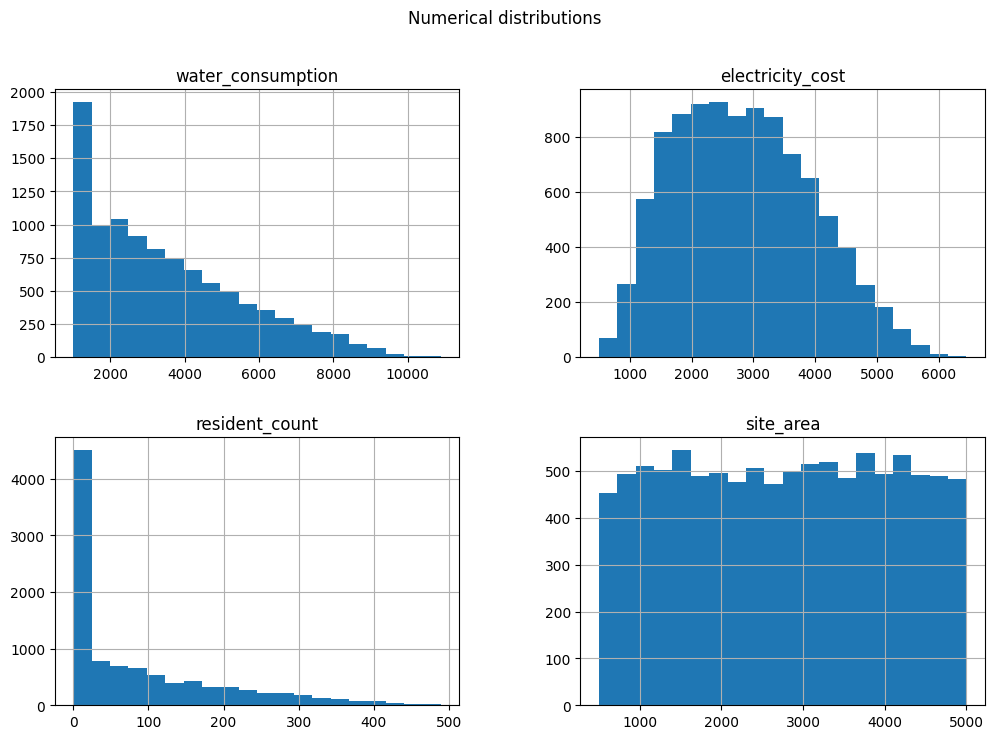

In [65]:
numeric_cols = ['water_consumption','electricity_cost','resident_count','site_area']
df[numeric_cols].hist(figsize=(12, 8), bins=20)
plt.suptitle("Numerical distributions")
plt.show()

The histograms show that electricity_cost is roughly normally distributed, making it suitable for regression. water_consumption and resident_count are highly right-skewed, indicating most values are low with a few high outliers—these may benefit from log transformation. In contrast, site_area appears uniformly distributed, requiring no transformation.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_31156\3638307519.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='structure_type', data=df, palette='viridis')


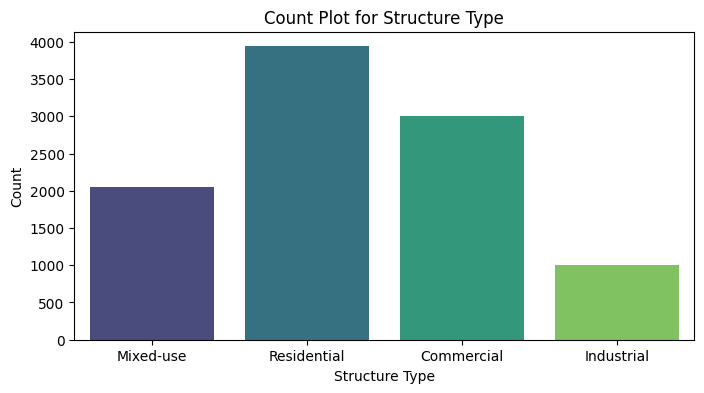

In [66]:
plt.figure(figsize=(8, 4))
sns.countplot(x='structure_type', data=df, palette='viridis')
plt.title('Count Plot for Structure Type')
plt.xlabel('Structure Type')
plt.ylabel('Count')
plt.show()

The chart shows that most buildings are Residential, followed by Commercial, then Mixed-use, and the least are Industria

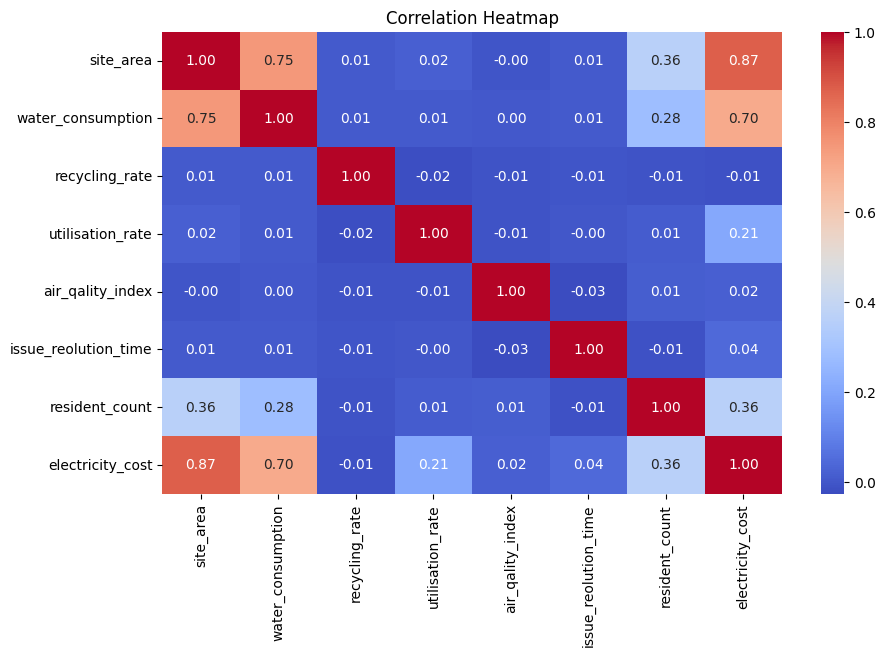

In [67]:
numeric_df = df.select_dtypes(include='number')
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


heatmap tells  how strongly the features are connected to each other. We can see that electricity cost increases when the site area is bigger and water consumption is higher  these two have the strongest connection There is also a small connection with resident count meaning more people might also lead to more electricity use.
But features like recycling rate, air quality, and issue resolution time don’t really affect the electricity cost much

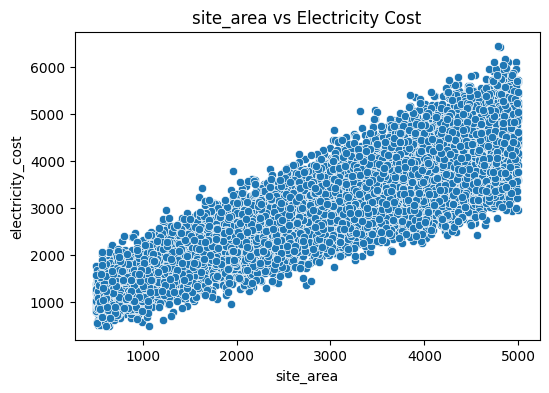

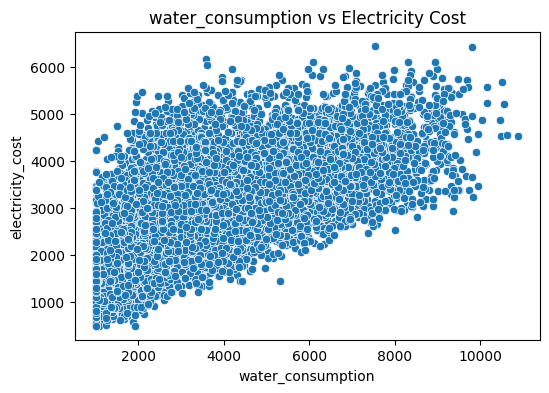

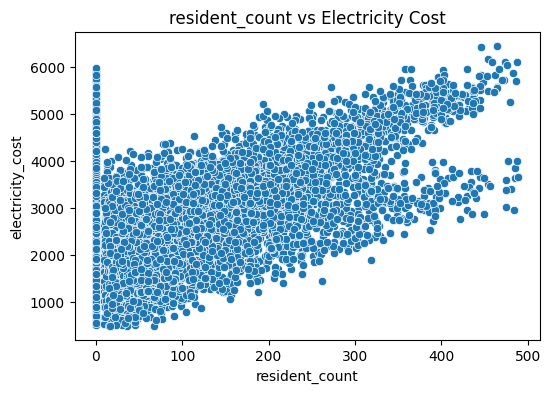

In [68]:
features = ['site_area', 'water_consumption','resident_count']
for feature in features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df[feature], y=df['electricity_cost'])
    plt.title(f'{feature} vs Electricity Cost')
    plt.show()

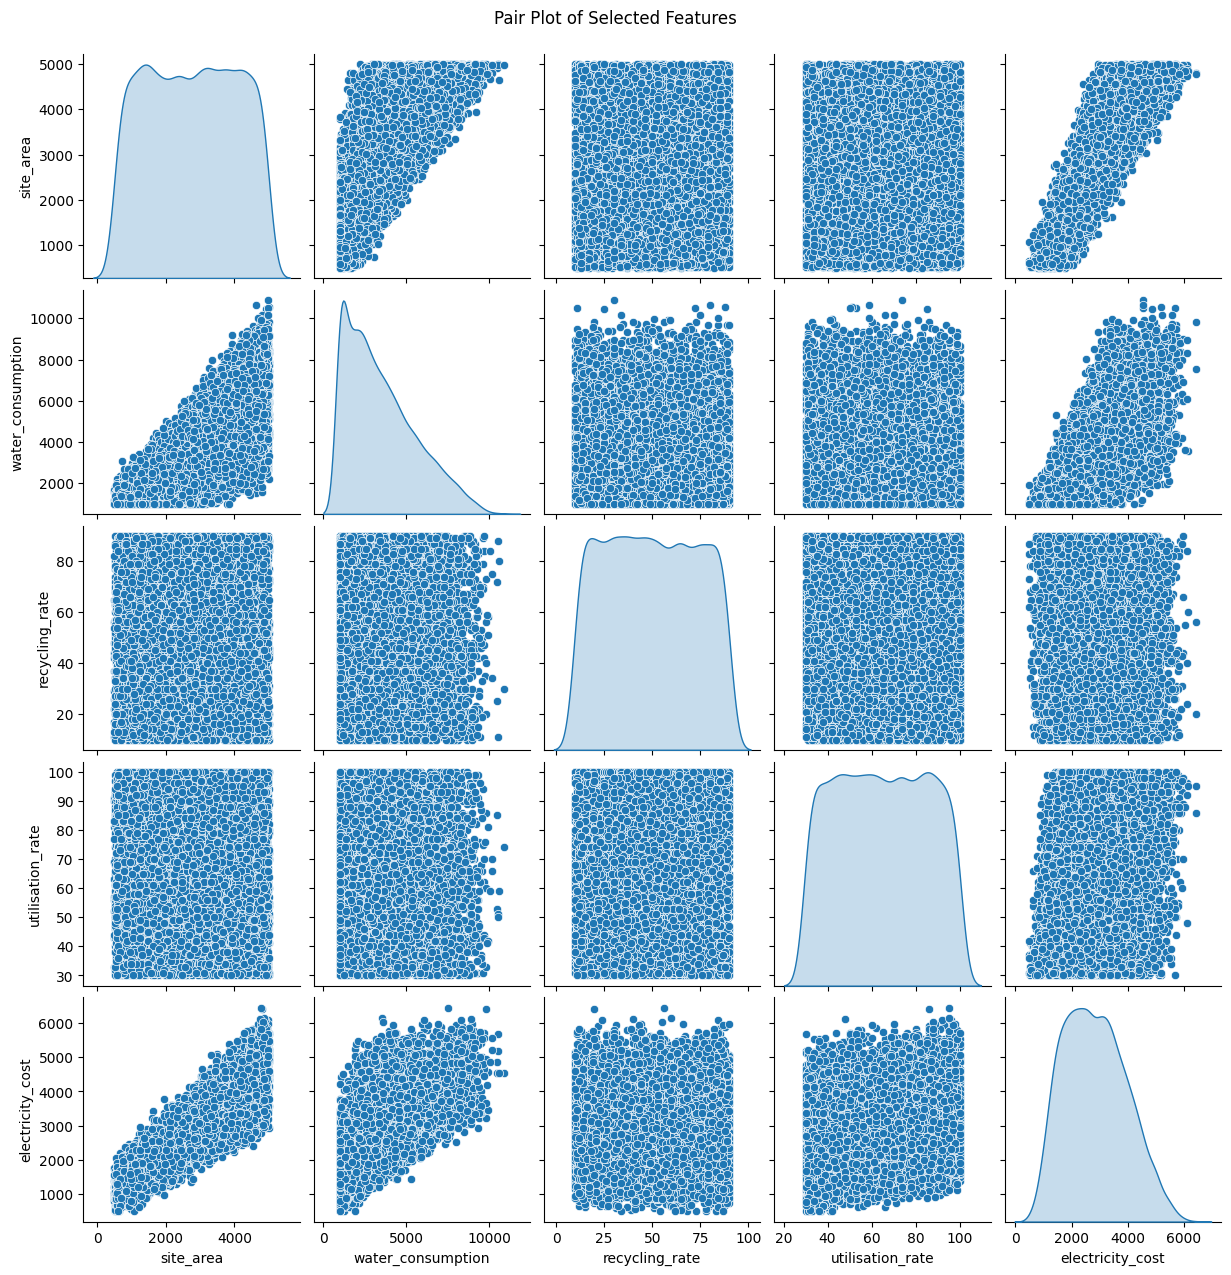

In [69]:
selected_features = ['site_area', 'water_consumption', 'recycling_rate', 'utilisation_rate', 'electricity_cost']
sns.pairplot(df[selected_features], diag_kind='kde')
plt.suptitle('Pair Plot of Selected Features', y=1.02)
plt.show()

pair plot shows that electricity cost increases with both site area and water consumption, as the points form an upward trend. This means bigger buildings using more water tend to have higher electricity bills. Other features like recycling rate and utilisation rate don’t show any clear pattern with electricity cost

# EDA summary


-  site_area                                                   Very strong                              Larger area = Higher cost  

-  structure_type_Mixed-use                                    Strong                                   Mixed-use = Higher cost   

-  utilisation_rate                                            Strong                                   Higher usage = Higher cost  

-  resident_count                                              Moderate                                 Higher count = Higher or flat cost

-  structure_type_Industrial                                   Moderate                                 Industrial = Lower cost (mostly)

-  water_consumption                                           Mild                                     Higher water = Higher electricity cost 

-  Other structure types, AQI, recycling                       Mild to negligible                       Mostly neutral or slightly negative     

In [70]:
# Summary statistics
print("Summary Statistics:")
print(df.describe())

Summary Statistics:
          site_area  water_consumption  recycling_rate  utilisation_rate  \
count  10000.000000       10000.000000    10000.000000      10000.000000   
mean    2757.775100        3494.057100       49.598000         64.842200   
std     1293.059959        2076.181117       23.430141         20.432965   
min      501.000000        1000.000000       10.000000         30.000000   
25%     1624.000000        1779.000000       29.750000         47.000000   
50%     2773.500000        3047.500000       49.000000         65.000000   
75%     3874.000000        4811.000000       70.000000         83.000000   
max     5000.000000       10894.000000       90.000000        100.000000   

       air_qality_index  issue_reolution_time  resident_count  \
count      10000.000000          10000.000000    10000.000000   
mean          99.468600             36.402600       85.573100   
std           58.014526             20.623905      107.876179   
min            0.000000            

In [71]:
df['water_consumption'] = np.log1p(df['water_consumption'])
df['resident_count'] = np.log1p(df['resident_count'])


In [72]:
df=pd.get_dummies(df)
df_copy = df.copy()
X=df.drop('electricity_cost',axis=1)
y=df['electricity_cost']

expected_columns = X.columns.tolist()

In [73]:
scaler = StandardScaler()
X= scaler.fit_transform(X)

In [74]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =0.2,random_state=42)

In [75]:
def model(regressor):
    regressor.fit(X_train, y_train)
    pred_y_test = regressor.predict(X_test)
    pred_y_train = regressor.predict(X_train)
    r = {
        "r2_score_test": r2_score(y_test, pred_y_test),
        "mean_absolute_error_test": mean_absolute_error(y_test, pred_y_test),
        "mean_squared_error_test": np.sqrt(mean_squared_error(y_test, pred_y_test)),
        "r2_score_train": r2_score(y_train, pred_y_train),
        "mean_absolute_error_train": mean_absolute_error(y_train, pred_y_train),
        "mean_squared_error_train": np.sqrt(mean_squared_error(y_train, pred_y_train)),
    }

    return r


In [76]:
model_result = {}
model_result['RandomForestRegressor']=model(RandomForestRegressor())
model_result['GradientBoostingRegressor']=model(GradientBoostingRegressor())
model_result['XGBoostingRegressor']=model(XGBRegressor()) 
model_result['LinearRegressor']=model(LinearRegression()) 

In [77]:
model_df=pd.DataFrame(model_result)
model_df.head(6)

,RandomForestRegressor,GradientBoostingRegressor,XGBoostingRegressor,LinearRegressor
r2_score_test,0.961013,0.960798,0.959311,0.917313
mean_absolute_error_test,175.384900,176.044877,179.778646,253.299418
mean_squared_error_test,220.536063,221.143129,225.297220,321.171430
r2_score_train,0.994280,0.964519,0.988825,0.915506
mean_absolute_error_train,66.262636,165.635867,89.252942,249.243013
mean_squared_error_train,83.522049,208.016527,116.743043,321.007058


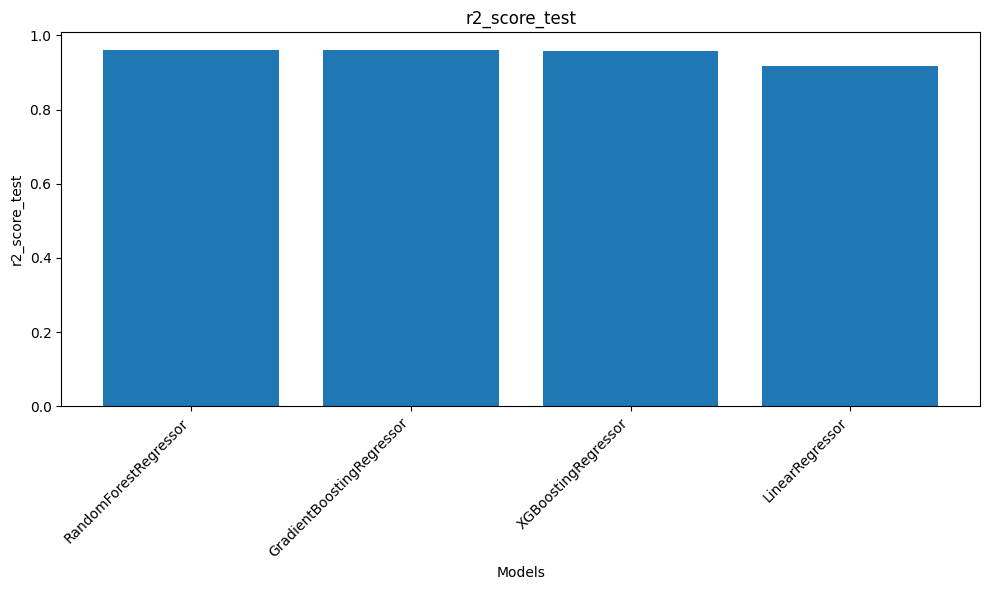

In [78]:
to_plot = 'r2_score_test'

plt.figure(figsize=(10, 6))
plt.bar(x=model_df.columns, height=model_df.loc[to_plot])
plt.xlabel("Models")
plt.ylabel(to_plot)
plt.title(f"{to_plot}")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- **RandomForestRegressor**, **GradientBoostingRegressor**, and **XGBoostingRegressor** perform almost equally and **slightly better** than **LinearRegression**.
- **LinearRegression** still performs well but has the **lowest R² score** among the four.


**Conclusion:** Tree-based models give the best results 

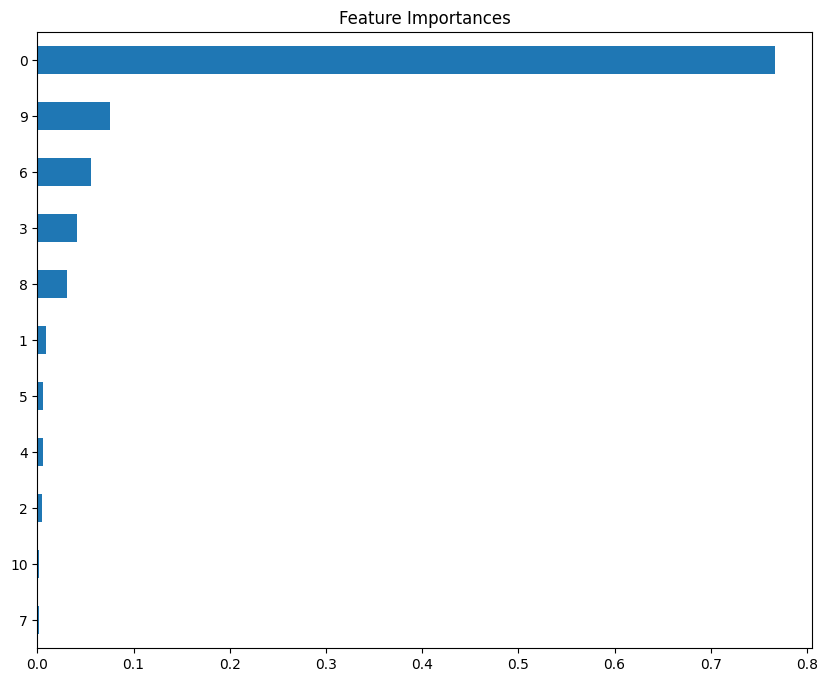

In [79]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Plot feature importances
importances = pd.Series(model.feature_importances_, )
importances.sort_values(ascending=True).plot(kind='barh', figsize=(10, 8))
plt.title("Feature Importances")
plt.show()


In [80]:
def Grid_Search_CV_RFR(X_train, y_train):
    # Define the model
    regressor = RandomForestRegressor()

    # Define hyperparameter grid (no need for regressor__ prefix now)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    }

    # Run GridSearchCV
    grid = GridSearchCV(estimator=regressor, param_grid=param_grid, n_jobs=-1, cv=5, verbose=1)
    grid.fit(X_train, y_train)

    return grid.best_score_, grid.best_params_, grid.best_estimator_

In [81]:
# Grid_Search_CV_RFR(X_train,y_train)

In [82]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import joblib

# Features
categorical_features = ["structure_type"]
numeric_features = [
    "site_area", "water_consumption", "resident_count",
    "issue_reolution_time", "utilisation_rate", "air_qality_index", "recycling_rate"
]

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(), categorical_features),
        ("num", "passthrough", numeric_features)
    ]
)

# Full pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(
        max_depth=10,
        max_features=None,
        min_samples_leaf=4,
        min_samples_split=5,
        n_estimators=100,
        random_state=42
    ))
])

# Split & train
X=df1.drop('electricity_cost',axis=1)
y=df1['electricity_cost']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
rf_residuals = y_test - y_pred
print(r2_score(y_test,y_pred))

0.958492490595462


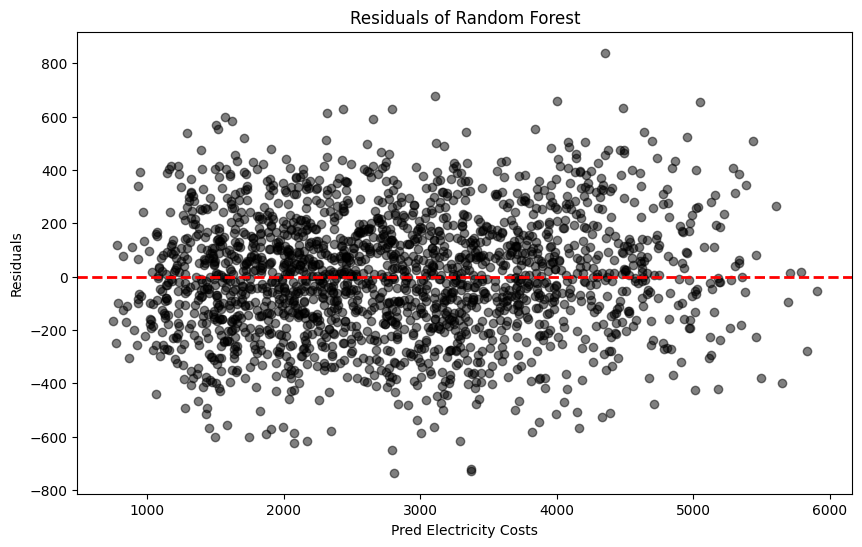

In [83]:

# Visualize residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, rf_residuals, alpha=0.5, color='black')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Residuals of Random Forest')
plt.xlabel('Pred Electricity Costs')
plt.ylabel('Residuals')
plt.show()

In [84]:
joblib.dump(pipeline, "final_pipeline.pkl")   

['final_pipeline.pkl']